In [932]:
import numpy as np
import scipy as sci
import scipy.io
from sklearn import svm
from skimage import feature
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import csv
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import Imputer
import sklearn.preprocessing as pp
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
import math
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [935]:
def create_csv(pred, name):
    np.savetxt(name, np.dstack((np.arange(1, len(pred)+1), pred))[0],"%d,%d",header="Id,Category")

def benchmark(pred_labels, true_labels):
    errors = pred_labels != true_labels
    err_rate = sum(errors) / float(len(true_labels))
    indices = errors.nonzero()
    return err_rate, indices


## 1. K-means Clustering 

In [936]:
# initialize data
train = scipy.io.loadmat("data/mnist_data/images.mat")

images = train['images']
    
images_reshaped = np.zeros((60000, 28*28))
for i in range(60000):
    curr = []
    for j in range(28):
        for k in range(28):
            curr.append(images[j][k][i])
    images_reshaped[i] = curr

In [945]:
def k_means(images, num_clusters, num_iters = 30):
    # choose clusters points as centers
    center_locs = []
    centers = []
    clusters = []

    prev_loss = -1
    for i in range(num_clusters):
        new_center = np.random.randint(len(images))
        while (new_center in center_locs):
            new_center = np.random.randint(len(images))
        center_locs.append(new_center)
        centers.append(images[new_center])
        clusters.append([])

    total_loss = 0
    curr_iters = 0
    while (prev_loss != total_loss and curr_iters < num_iters):
        prev_loss = total_loss
        total_loss = 0
        # assign points to clusters
        for image in images:
            best_center = 0
            best_dist = np.linalg.norm(image - centers[0])
            for i in range(len(centers)):
                dist = np.linalg.norm(image - centers[i])
                if dist < best_dist:
                    best_center = i
                    best_dist = dist
            # find loss
            clusters[best_center].append(image)
            total_loss += best_dist

        # update centers
        for i in range(len(clusters)):
            updated_center = np.mean(clusters[i], axis=0)
            centers[i] = updated_center
            
        curr_iters+=1    
    return centers, clusters, total_loss

It took 252.65116500854492 seconds to run.
These are the cluster centers for k = 5


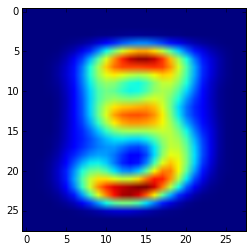

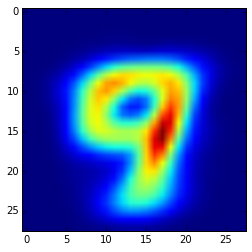

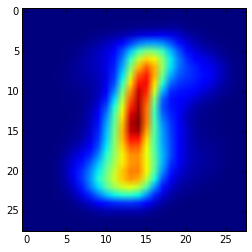

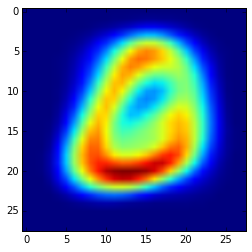

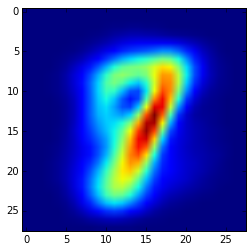

It took 244.36503195762634 seconds to run.
These are the cluster centers for k = 10


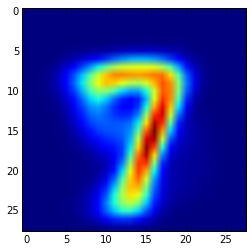

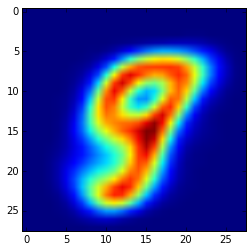

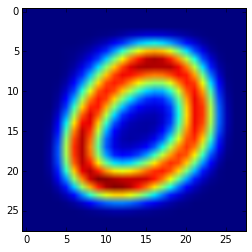

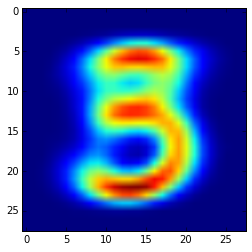

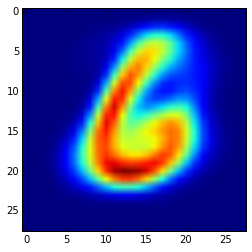

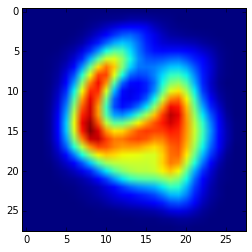

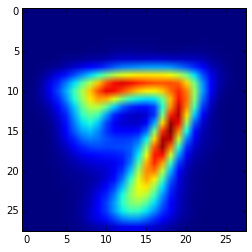

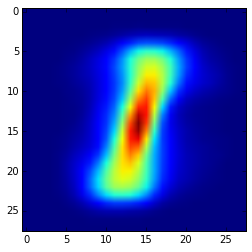

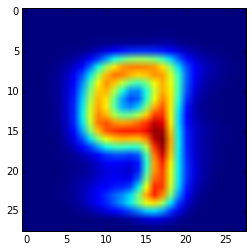

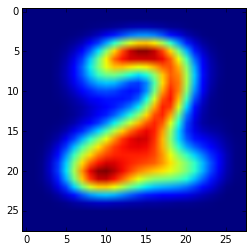

It took 340.7444980144501 seconds to run.
These are the cluster centers for k = 20


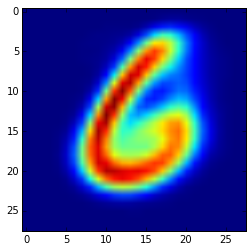

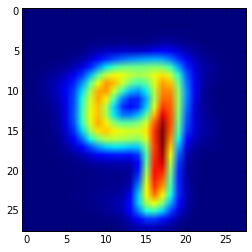

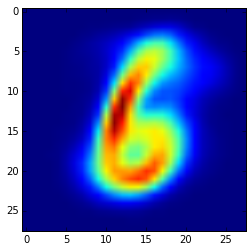

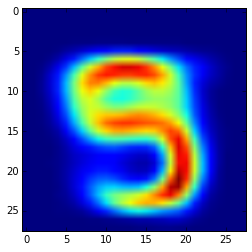

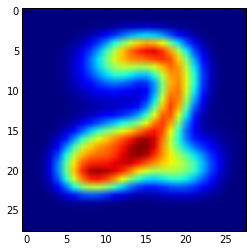

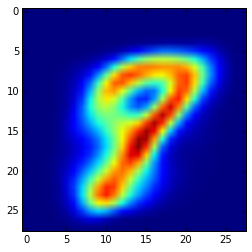

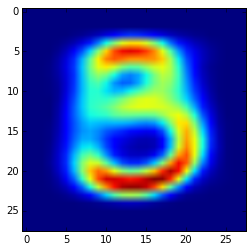

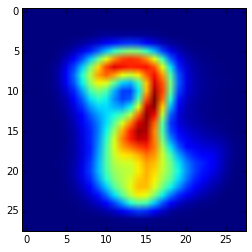

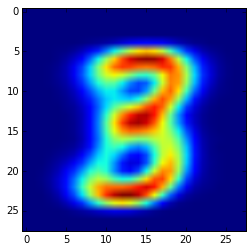

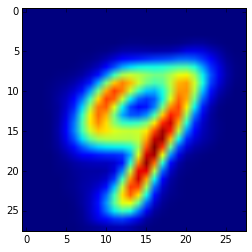

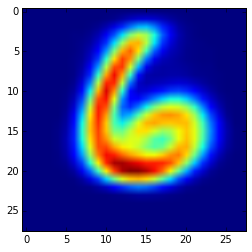

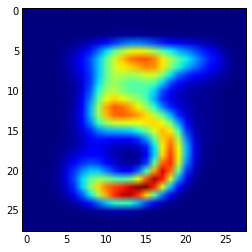

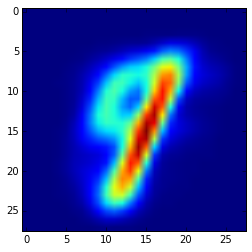

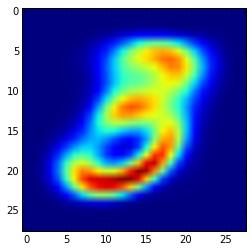

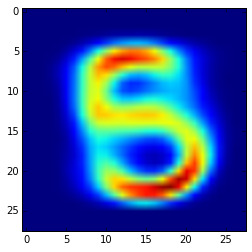

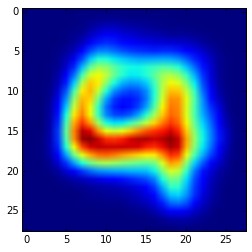

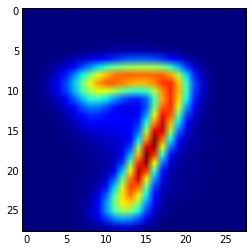

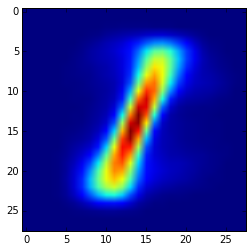

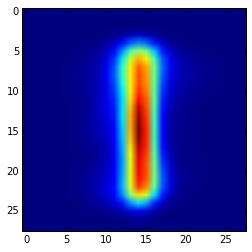

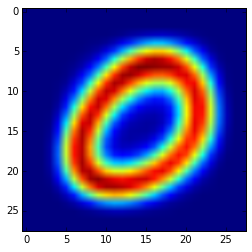

In [946]:
k_list = [5, 10, 20]
for num_centers in k_list:
    start = time.time()
    centers, clusters, total_loss = k_means(images_reshaped, num_centers)
    end = time.time()
    print("It took", end-start, "seconds to run.")
    print("These are the cluster centers for k =", num_centers)
    for i in range(num_centers):
        plt.imshow(centers[i].reshape((28, 28)))
        plt.show()

In [947]:
num_centers = 5
for i in range(4):
    start = time.time()
    centers, clusters, total_loss = k_means(images_reshaped, num_centers)
    end = time.time()
    print("It took", end-start, "seconds to run.")
    print("The k-means loss is:", total_loss)
    

It took 198.01977705955505 seconds to run.
The k-means loss is: 103274112.975
It took 199.21791100502014 seconds to run.
The k-means loss is: 103052628.99
It took 195.5544970035553 seconds to run.
The k-means loss is: 102649637.438
It took 193.31299495697021 seconds to run.
The k-means loss is: 103040876.309


The k-means loss does vary with multiple iterations.

## Question 2:

In [948]:
train = scipy.io.loadmat("data/joke_data/joke_train.mat")
jokes = train['train']

## 2.2 Warm-up

In [949]:
f = open("data/joke_data/validation.txt", 'r')
val_set = []
val_labels = []

for line in f:
    words = line.split(',')
    val_set.append((int(words[0]), int(words[1])))
    val_labels.append(int(words[2]))
val_labels = np.array(val_labels)

## Prediction by average

In [950]:
def predict_averages(jokes, val_set):
    averages = np.nanmean(jokes, axis=0)
    predictions = []
    for i in val_set:
        joke = i[1]-1
        if averages[joke] > 0:
            predictions.append(1)
        else:
            predictions.append(0)
    return np.array(predictions)

In [951]:
pred = predict_averages(jokes, val_set)
error_rate, indices = benchmark(pred, val_labels)
print("The accuracy for the simple classifier is", 1-error_rate)

The accuracy for the simple classifier is 0.620325203252


## Prediction by k Nearest Neighbors

In [952]:
def nan_to_zero(data):
    for row in data:
        if np.isnan(row).any():
            for i in range(len(row)):
                if np.isnan(row[i]):
                    row[i] = 0
                    
def kNN(jokes, val_set, k=10):
    users = {}
    predictions = []
    for i in val_set:
        # indexing
        user = i[0]-1
        if not user in users:
            users[user] = getKNN(jokes, user, k)
        # jank
        a = []
        a.append(i)
        predictions.append(predict_averages(jokes[users[user]], a)[0])
    return predictions
        
def getKNN(jokes, user, k):
    best = []
    distances = []
    for i in range(len(jokes)):
        if i == user:
            continue
        dist = np.linalg.norm(jokes[i] - jokes[user])
        distances.append((dist, i))
    distances = sorted(distances, key=lambda x: x[0])
    for val in range(k):
        best.append(distances[val][1])
    return best

In [953]:
# change NaN values to zeroes
nan_to_zero(jokes)

In [954]:
k_list = [10, 100, 1000]
for k_val in k_list:
    start = time.time()
    kNN_pred = kNN(jokes, val_set, k=k_val)
    end = time.time()
    print("It took", end-start, "seconds")
    error_rate, indices = benchmark(kNN_pred, val_labels)
    print("The accuracy for kNN with k =", k_val, "is", 1-error_rate)
    print()

It took 18.722891092300415 seconds
The accuracy for kNN with k = 10 is 0.649051490515

It took 18.740540027618408 seconds
The accuracy for kNN with k = 100 is 0.689430894309

It took 24.163990020751953 seconds
The accuracy for kNN with k = 1000 is 0.694037940379



The accuracies of the k nearest neighbors classifiers are better than the accuracies of the simple prediction using averages.

##2.3 Latent Factor Model

In [955]:
u, s, v = np.linalg.svd(jokes, full_matrices = False)
s = np.diag(s)

In [965]:
# projecting down to smaller space
d = 5
# lower dimensional representation for users
u2 = u.T[:d].T
# lower dimensional representation for jokes
v2 = v[:d]
s2 = s.T[:d].T
s2 = s2[:d]
projection = u2.dot(s2.dot(v2))

In [959]:
def MSE(data, u, s, v):        
    error = np.sum(np.square(u.dot(s.dot(v))-data))
    return error

def predict_inner_prod(val_set, u, s, v):
    predictions = []
    ratings = u.dot(s.dot(v))
    for i in val_set:
        user = i[0]-1
        joke = i[1]-1
        if ratings[user][joke] > 0:
            predictions.append(1)
        else:
            predictions.append(0)
    return np.array(predictions)

In [960]:
d_list = [2, 5, 10, 20]

for d in d_list:
    u2 = u.T[:d].T
    v2 = v[:d]
    s2 = s.T[:d].T
    s2 = s2[:d]
    error = MSE(jokes, u2, s2, v2)
    pred = predict_inner_prod(val_set, u2, s2, v2)
    error_rate, indices = benchmark(pred, val_labels)
    print("MSE for d =", d, "is", error)
    print("Accuracy for d =", d, "is", 1-error_rate)
    print()

MSE for d = 2 is 20814819.1728
Accuracy for d = 2 is 0.705149051491

MSE for d = 5 is 19264405.1575
Accuracy for d = 5 is 0.715447154472

MSE for d = 10 is 17415305.8624
Accuracy for d = 10 is 0.716531165312

MSE for d = 20 is 14466309.8038
Accuracy for d = 20 is 0.685907859079



As d increases, the MSE decreases.

In [961]:
def MSE_LFM(data, u, v):
    # tke care of NaN cases?
    error = np.sum(np.square(u.dot(v)-data))
    return error

def LFM(r, uin, vin, num_iters = 600, l = 500, learn = 0.0002, d_val=10):
    u = 0.1* np.random.randn(24983, d)
    v = 0.1* np.random.randn(d, 100)
    x_vals = []
    errors = []
    curr_iters = 0
    while curr_iters < num_iters:
        gradu = 2*u.dot(v).dot(v.T)-2*r.dot(v.T) + 2*l*u
        gradv = 2*u.T.dot(u).dot(v)-2*u.T.dot(r) + 2*l*v
        u = u - learn * gradu
        v = v - learn * gradv

        if curr_iters % 10 == 0:
            x_vals.append(curr_iters)
            error = MSE_LFM(r, u, v)
            errors.append(error)
        curr_iters+=1
        
    return u, v, x_vals, errors

It took 12.257079124450684 seconds to finish
MSE for d = 2 is 21314819.1728
Validation accuracy is 0.70379403794



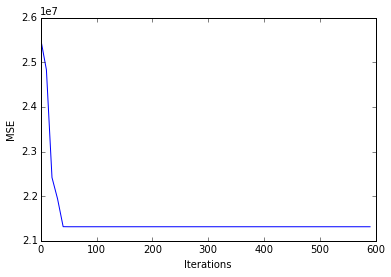

It took 12.521260023117065 seconds to finish
MSE for d = 5 is 20514405.1583
Validation accuracy is 0.713279132791



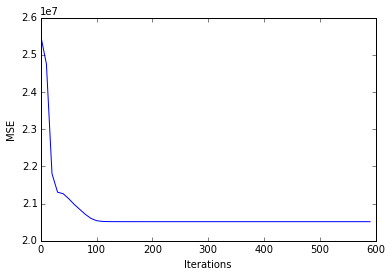

It took 18.228029012680054 seconds to finish
MSE for d = 10 is 19915382.4426
Validation accuracy is 0.711924119241



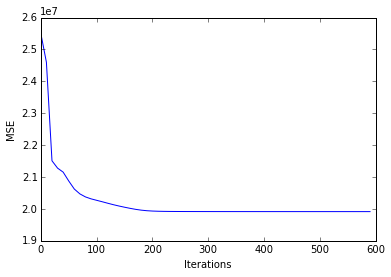

It took 21.754854917526245 seconds to finish
MSE for d = 20 is 19471339.8056
Validation accuracy is 0.718157181572



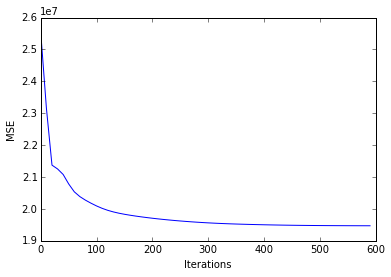

In [982]:
d_list = [2, 5, 10, 20]

for d in d_list:
    u2 = u.T[:d].T
    v2 = v[:d]
    s2 = s.T[:d].T
    s2 = s2[:d]

    start = time.time()
    u_LFM, v_LFM, x_vals, MSE_vals = LFM(jokes, u2, v2, l = 500, d_val = d)
    error = MSE_LFM(jokes, u_LFM, v_LFM)
    pred = predict_inner_prod(val_set, u_LFM, s2, v_LFM)
    error_rate, indices = benchmark(pred, val_labels)
    end = time.time()
    print("It took", end-start, "seconds to finish")
    print("MSE for d =", d, "is", error)
    print("Validation accuracy is", 1-error_rate)
    print()
    plt.plot(x_vals, MSE_vals)
    plt.xlabel("Iterations")
    plt.ylabel("MSE")
    plt.show()

The resulting MSE is higher than the one we found in part 2 for each value of d, but the validation accuracy is higher.

##2.4 Recommending Jokes (Kaggle)

In [966]:
f = open("data/joke_data/query.txt", 'r')
train_set = []

for line in f:
    words = line.split(',')
    train_set.append((int(words[1]), int(words[2])))
f.close()

It took 51.67404103279114 seconds to finish
MSE for d = 30 is 18611164.8571
Validation accuracy is 0.728997289973



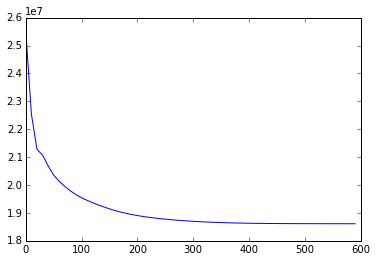

In [1005]:
d = 30

u2 = u.T[:d].T
v2 = v[:d]
s2 = s.T[:d].T
s2 = s2[:d]

start = time.time()
u_LFM, v_LFM, x_vals, MSE_vals = LFM(jokes, u2, v2, l = 475, learn = 0.0002, d_val = d)
error = MSE_LFM(jokes, u_LFM, v_LFM)
pred = predict_inner_prod(val_set, u_LFM, s2, v_LFM)
error_rate, indices = benchmark(pred, val_labels)
end = time.time()
print("It took", end-start, "seconds to finish")
print("MSE for d =", d, "is", error)
print("Validation accuracy is", 1-error_rate)
print()
plt.plot(x_vals, MSE_vals)

In [1006]:
pred = predict_inner_prod(train_set, u_LFM, s2, v_LFM)

In [1007]:
f = open("kaggle_submission.txt", 'w')
f.write("Id,Category\n")
for i in range(len(pred)):
    f.write(str(i+1) + ", " + str(pred[i]) + "\n")
f.close()

The best Kaggle score I got was 0.71175